## Predicting if Business is Open/Close

We will use supervised ML model to predict if the restaurant is closed or open. 

Metrics to be used to evaluate each models are:
- accuracy
- precision
- recall
- f1 score
- ROC Curve
- Precision-Recall Curve


In [1]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score, \
                            roc_curve, roc_auc_score, precision_recall_curve, plot_confusion_matrix
from sklearn.datasets import dump_svmlight_file


%matplotlib inline

### Import restaurant dataframes

In [2]:
df_restaurants = pd.read_pickle('./data/restaurants_cleaned.pkl')

In [3]:
df_restaurants.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,lot,street,valet,validated,RestaurantsAttire,NoiseLevel,WiFi,Alcohol,chain,sentiment_final
0,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,...,False,False,False,False,casual,2,True,beer_and_wine,0,0.366400
1,HPA_qyMEddpAEtFof02ixg,Mr G's Pizza & Subs,474 Lowell St,Peabody,MA,01960,42.541155,-70.973438,4.0,39,...,True,False,False,False,casual,2,True,NaN,0,0.132592
2,jGennaZUr2MsJyRhijNBfA,Legal Sea Foods,1 Harborside Dr,Boston,MA,02128,42.363442,-71.025781,3.5,856,...,False,False,False,False,casual,2,True,full_bar,1,0.090394
3,iPD8BBvea6YldQZPHzVrSQ,Espresso Minute,334 Mass Ave,Boston,MA,02115,42.342673,-71.084239,4.5,7,...,False,False,False,False,casual,1,NaN,NaN,0,0.655234
4,jx91IMdGOmLOo8h_F9z39g,Cleary's Restaurant & Spirits,12429 NE Glisan St,Portland,OR,97230,45.526473,-122.535323,3.5,19,...,True,False,False,False,casual,2,NaN,full_bar,0,-0.114162


In [4]:
df_restaurants.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16256 entries, 0 to 16255
Data columns (total 43 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   business_id                 16256 non-null  object 
 1   name                        16256 non-null  object 
 2   address                     16256 non-null  object 
 3   city                        16256 non-null  object 
 4   state                       16256 non-null  object 
 5   postal_code                 16256 non-null  object 
 6   latitude                    16256 non-null  float64
 7   longitude                   16256 non-null  float64
 8   stars                       16256 non-null  float64
 9   review_count                16256 non-null  int64  
 10  is_open                     16256 non-null  int64  
 11  category                    16256 non-null  object 
 12  RestaurantsTakeOut          15136 non-null  object 
 13  GoodForKids                 136

In [5]:
# filter out the columns to drop
cols_drop = ['business_id','name','address', 'postal_code','state','latitude','longitude','city']

In [6]:
df_restaurants_drop = df_restaurants.drop(columns= cols_drop)

In [16]:
df_restaurants_drop

,stars,review_count,is_open,category,RestaurantsTakeOut,GoodForKids,BikeParking,OutdoorSeating,Caters,RestaurantsReservations,...,lot,street,valet,validated,RestaurantsAttire,NoiseLevel,WiFi,Alcohol,chain,sentiment_final
0,4.0,126,1,Vegetarian/Vegan,True,True,False,False,True,False,...,False,False,False,False,casual,2,True,beer_and_wine,0,0.366400
1,4.0,39,1,Western,True,True,True,True,True,False,...,True,False,False,False,casual,2,True,NaN,0,0.132592
2,3.5,856,1,Italian,True,True,False,False,False,False,...,False,False,False,False,casual,2,True,full_bar,1,0.090394
3,4.5,7,0,Cafes,True,True,True,True,True,False,...,False,False,False,False,casual,1,NaN,NaN,0,0.655234
4,3.5,19,1,Nightlife,True,True,True,False,NaN,False,...,True,False,False,False,casual,2,NaN,full_bar,0,-0.114162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16251,4.0,137,1,American,True,True,True,True,True,False,...,True,True,False,False,casual,2,True,beer_and_wine,0,0.583473
16252,5.0,733,1,Italian,True,True,False,True,False,False,...,True,False,False,False,casual,2,NaN,beer_and_wine,0,0.676805
16253,3.0,30,0,American,True,False,NaN,False,NaN,True,...,False,True,False,False,casual,0,NaN,full_bar,0,-0.182383
16254,2.0,48,0,American,False,False,NaN,True,False,True,...,False,False,True,False,casual,2,NaN,full_bar,0,-0.631424


In [52]:
df_restaurants_drop.is_open.value_counts()

1    9789
0    6467
Name: is_open, dtype: int64

In [8]:
#!pip install pycaret --user
#!pip install shap

In [9]:
import numpy as np
import pandas as pd

In [10]:
from pycaret.classification import *

In [11]:
from pycaret import classification

## Prepare the environment


In [18]:
grid = setup(data=df_restaurants_drop, target='is_open',
            html=False, silent=True, verbose=True, log_experiment= True, experiment_name = 'restaurants',data_split_stratify=True, feature_selection=True)

Setup Succesfully Completed!


,Description,Value
0,session_id,5993
1,Target,is_open
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(16256, 35)"
5,Missing Values,True
6,Numeric Features,4
7,Categorical Features,30
8,Ordinal Features,False
9,High Cardinality Features,False


## Train and evaluate the performance of all estimators available in the model library using K-fold validation

In [19]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7996,0.8591,0.8701,0.811,0.8395,0.5738,0.5765,0.931


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7996,0.8591,0.8701,0.8110,0.8395,0.5738,0.5765,0.931
knn,K Neighbors Classifier,0.7326,0.7735,0.8033,0.7647,0.7834,0.4345,0.4355,0.261


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7996,0.8591,0.8701,0.8110,0.8395,0.5738,0.5765,0.931
knn,K Neighbors Classifier,0.7326,0.7735,0.8033,0.7647,0.7834,0.4345,0.4355,0.261
nb,Naive Bayes,0.5651,0.7972,0.3199,0.8842,0.4695,0.2200,0.3038,0.025


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7996,0.8591,0.8701,0.8110,0.8395,0.5738,0.5765,0.931
knn,K Neighbors Classifier,0.7326,0.7735,0.8033,0.7647,0.7834,0.4345,0.4355,0.261
dt,Decision Tree Classifier,0.7285,0.7181,0.7693,0.7777,0.7734,0.4349,0.4351,0.037
nb,Naive Bayes,0.5651,0.7972,0.3199,0.8842,0.4695,0.2200,0.3038,0.025


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7996,0.8591,0.8701,0.8110,0.8395,0.5738,0.5765,0.931
knn,K Neighbors Classifier,0.7326,0.7735,0.8033,0.7647,0.7834,0.4345,0.4355,0.261
dt,Decision Tree Classifier,0.7285,0.7181,0.7693,0.7777,0.7734,0.4349,0.4351,0.037
svm,SVM - Linear Kernel,0.7131,0.0000,0.8390,0.7490,0.7622,0.3769,0.4283,0.041
nb,Naive Bayes,0.5651,0.7972,0.3199,0.8842,0.4695,0.2200,0.3038,0.025


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7996,0.8591,0.8701,0.8110,0.8395,0.5738,0.5765,0.931
ridge,Ridge Classifier,0.7979,0.0000,0.8813,0.8025,0.8400,0.5672,0.5721,0.024
knn,K Neighbors Classifier,0.7326,0.7735,0.8033,0.7647,0.7834,0.4345,0.4355,0.261
dt,Decision Tree Classifier,0.7285,0.7181,0.7693,0.7777,0.7734,0.4349,0.4351,0.037
svm,SVM - Linear Kernel,0.7131,0.0000,0.8390,0.7490,0.7622,0.3769,0.4283,0.041
nb,Naive Bayes,0.5651,0.7972,0.3199,0.8842,0.4695,0.2200,0.3038,0.025


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8140,0.8732,0.8936,0.8154,0.8527,0.6020,0.6069,0.225
lr,Logistic Regression,0.7996,0.8591,0.8701,0.8110,0.8395,0.5738,0.5765,0.931
ridge,Ridge Classifier,0.7979,0.0000,0.8813,0.8025,0.8400,0.5672,0.5721,0.024
knn,K Neighbors Classifier,0.7326,0.7735,0.8033,0.7647,0.7834,0.4345,0.4355,0.261
dt,Decision Tree Classifier,0.7285,0.7181,0.7693,0.7777,0.7734,0.4349,0.4351,0.037
svm,SVM - Linear Kernel,0.7131,0.0000,0.8390,0.7490,0.7622,0.3769,0.4283,0.041
nb,Naive Bayes,0.5651,0.7972,0.3199,0.8842,0.4695,0.2200,0.3038,0.025


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8140,0.8732,0.8936,0.8154,0.8527,0.6020,0.6069,0.225
lr,Logistic Regression,0.7996,0.8591,0.8701,0.8110,0.8395,0.5738,0.5765,0.931
ridge,Ridge Classifier,0.7979,0.0000,0.8813,0.8025,0.8400,0.5672,0.5721,0.024
knn,K Neighbors Classifier,0.7326,0.7735,0.8033,0.7647,0.7834,0.4345,0.4355,0.261
dt,Decision Tree Classifier,0.7285,0.7181,0.7693,0.7777,0.7734,0.4349,0.4351,0.037
svm,SVM - Linear Kernel,0.7131,0.0000,0.8390,0.7490,0.7622,0.3769,0.4283,0.041
qda,Quadratic Discriminant Analysis,0.6571,0.7388,0.6991,0.7477,0.6891,0.2928,0.3269,0.037
nb,Naive Bayes,0.5651,0.7972,0.3199,0.8842,0.4695,0.2200,0.3038,0.025


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8140,0.8732,0.8936,0.8154,0.8527,0.6020,0.6069,0.225
lr,Logistic Regression,0.7996,0.8591,0.8701,0.8110,0.8395,0.5738,0.5765,0.931
ridge,Ridge Classifier,0.7979,0.0000,0.8813,0.8025,0.8400,0.5672,0.5721,0.024
ada,Ada Boost Classifier,0.7978,0.8586,0.8646,0.8119,0.8374,0.5708,0.5729,0.164
knn,K Neighbors Classifier,0.7326,0.7735,0.8033,0.7647,0.7834,0.4345,0.4355,0.261
dt,Decision Tree Classifier,0.7285,0.7181,0.7693,0.7777,0.7734,0.4349,0.4351,0.037
svm,SVM - Linear Kernel,0.7131,0.0000,0.8390,0.7490,0.7622,0.3769,0.4283,0.041
qda,Quadratic Discriminant Analysis,0.6571,0.7388,0.6991,0.7477,0.6891,0.2928,0.3269,0.037
nb,Naive Bayes,0.5651,0.7972,0.3199,0.8842,0.4695,0.2200,0.3038,0.025


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8140,0.8732,0.8936,0.8154,0.8527,0.6020,0.6069,0.225
gbc,Gradient Boosting Classifier,0.8099,0.8748,0.8955,0.8093,0.8501,0.5921,0.5981,0.381
lr,Logistic Regression,0.7996,0.8591,0.8701,0.8110,0.8395,0.5738,0.5765,0.931
ridge,Ridge Classifier,0.7979,0.0000,0.8813,0.8025,0.8400,0.5672,0.5721,0.024
ada,Ada Boost Classifier,0.7978,0.8586,0.8646,0.8119,0.8374,0.5708,0.5729,0.164
knn,K Neighbors Classifier,0.7326,0.7735,0.8033,0.7647,0.7834,0.4345,0.4355,0.261
dt,Decision Tree Classifier,0.7285,0.7181,0.7693,0.7777,0.7734,0.4349,0.4351,0.037
svm,SVM - Linear Kernel,0.7131,0.0000,0.8390,0.7490,0.7622,0.3769,0.4283,0.041
qda,Quadratic Discriminant Analysis,0.6571,0.7388,0.6991,0.7477,0.6891,0.2928,0.3269,0.037
nb,Naive Bayes,0.5651,0.7972,0.3199,0.8842,0.4695,0.2200,0.3038,0.025


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8140,0.8732,0.8936,0.8154,0.8527,0.6020,0.6069,0.225
gbc,Gradient Boosting Classifier,0.8099,0.8748,0.8955,0.8093,0.8501,0.5921,0.5981,0.381
lr,Logistic Regression,0.7996,0.8591,0.8701,0.8110,0.8395,0.5738,0.5765,0.931
ridge,Ridge Classifier,0.7979,0.0000,0.8813,0.8025,0.8400,0.5672,0.5721,0.024
ada,Ada Boost Classifier,0.7978,0.8586,0.8646,0.8119,0.8374,0.5708,0.5729,0.164
lda,Linear Discriminant Analysis,0.7978,0.8555,0.8799,0.8032,0.8397,0.5674,0.5720,0.073
knn,K Neighbors Classifier,0.7326,0.7735,0.8033,0.7647,0.7834,0.4345,0.4355,0.261
dt,Decision Tree Classifier,0.7285,0.7181,0.7693,0.7777,0.7734,0.4349,0.4351,0.037
svm,SVM - Linear Kernel,0.7131,0.0000,0.8390,0.7490,0.7622,0.3769,0.4283,0.041
qda,Quadratic Discriminant Analysis,0.6571,0.7388,0.6991,0.7477,0.6891,0.2928,0.3269,0.037


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8140,0.8732,0.8936,0.8154,0.8527,0.6020,0.6069,0.225
gbc,Gradient Boosting Classifier,0.8099,0.8748,0.8955,0.8093,0.8501,0.5921,0.5981,0.381
et,Extra Trees Classifier,0.8018,0.8579,0.8767,0.8101,0.8419,0.5774,0.5810,0.220
lr,Logistic Regression,0.7996,0.8591,0.8701,0.8110,0.8395,0.5738,0.5765,0.931
ridge,Ridge Classifier,0.7979,0.0000,0.8813,0.8025,0.8400,0.5672,0.5721,0.024
ada,Ada Boost Classifier,0.7978,0.8586,0.8646,0.8119,0.8374,0.5708,0.5729,0.164
lda,Linear Discriminant Analysis,0.7978,0.8555,0.8799,0.8032,0.8397,0.5674,0.5720,0.073
knn,K Neighbors Classifier,0.7326,0.7735,0.8033,0.7647,0.7834,0.4345,0.4355,0.261
dt,Decision Tree Classifier,0.7285,0.7181,0.7693,0.7777,0.7734,0.4349,0.4351,0.037
svm,SVM - Linear Kernel,0.7131,0.0000,0.8390,0.7490,0.7622,0.3769,0.4283,0.041


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8172,0.8812,0.8908,0.8210,0.8544,0.6100,0.6139,0.126
rf,Random Forest Classifier,0.8140,0.8732,0.8936,0.8154,0.8527,0.6020,0.6069,0.225
gbc,Gradient Boosting Classifier,0.8099,0.8748,0.8955,0.8093,0.8501,0.5921,0.5981,0.381
et,Extra Trees Classifier,0.8018,0.8579,0.8767,0.8101,0.8419,0.5774,0.5810,0.220
lr,Logistic Regression,0.7996,0.8591,0.8701,0.8110,0.8395,0.5738,0.5765,0.931
ridge,Ridge Classifier,0.7979,0.0000,0.8813,0.8025,0.8400,0.5672,0.5721,0.024
ada,Ada Boost Classifier,0.7978,0.8586,0.8646,0.8119,0.8374,0.5708,0.5729,0.164
lda,Linear Discriminant Analysis,0.7978,0.8555,0.8799,0.8032,0.8397,0.5674,0.5720,0.073
knn,K Neighbors Classifier,0.7326,0.7735,0.8033,0.7647,0.7834,0.4345,0.4355,0.261
dt,Decision Tree Classifier,0.7285,0.7181,0.7693,0.7777,0.7734,0.4349,0.4351,0.037


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8172,0.8812,0.8908,0.8210,0.8544,0.6100,0.6139,0.126
rf,Random Forest Classifier,0.8140,0.8732,0.8936,0.8154,0.8527,0.6020,0.6069,0.225
gbc,Gradient Boosting Classifier,0.8099,0.8748,0.8955,0.8093,0.8501,0.5921,0.5981,0.381
et,Extra Trees Classifier,0.8018,0.8579,0.8767,0.8101,0.8419,0.5774,0.5810,0.220
lr,Logistic Regression,0.7996,0.8591,0.8701,0.8110,0.8395,0.5738,0.5765,0.931
ridge,Ridge Classifier,0.7979,0.0000,0.8813,0.8025,0.8400,0.5672,0.5721,0.024
ada,Ada Boost Classifier,0.7978,0.8586,0.8646,0.8119,0.8374,0.5708,0.5729,0.164
lda,Linear Discriminant Analysis,0.7978,0.8555,0.8799,0.8032,0.8397,0.5674,0.5720,0.073
knn,K Neighbors Classifier,0.7326,0.7735,0.8033,0.7647,0.7834,0.4345,0.4355,0.261
dt,Decision Tree Classifier,0.7285,0.7181,0.7693,0.7777,0.7734,0.4349,0.4351,0.037


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8172,0.8812,0.8908,0.8210,0.8544,0.6100,0.6139,0.126
rf,Random Forest Classifier,0.8140,0.8732,0.8936,0.8154,0.8527,0.6020,0.6069,0.225
gbc,Gradient Boosting Classifier,0.8099,0.8748,0.8955,0.8093,0.8501,0.5921,0.5981,0.381
et,Extra Trees Classifier,0.8018,0.8579,0.8767,0.8101,0.8419,0.5774,0.5810,0.220
lr,Logistic Regression,0.7996,0.8591,0.8701,0.8110,0.8395,0.5738,0.5765,0.931
ridge,Ridge Classifier,0.7979,0.0000,0.8813,0.8025,0.8400,0.5672,0.5721,0.024
ada,Ada Boost Classifier,0.7978,0.8586,0.8646,0.8119,0.8374,0.5708,0.5729,0.164
lda,Linear Discriminant Analysis,0.7978,0.8555,0.8799,0.8032,0.8397,0.5674,0.5720,0.073
knn,K Neighbors Classifier,0.7326,0.7735,0.8033,0.7647,0.7834,0.4345,0.4355,0.261
dt,Decision Tree Classifier,0.7285,0.7181,0.7693,0.7777,0.7734,0.4349,0.4351,0.037


Based on the best models comparision, Light Gradient Boosting Machine, Random Forest Classifier, Gradient Boosting Classifier and Extra Trees Classifier gives accuracy score more than 80%.

## Evaluation individual model and fine tune the model. 

### 01 Light Gradient Boosting Machine

In [20]:
# create model
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8339,0.8919,0.9009,0.8363,0.8674,0.6461,0.6493
1,0.8155,0.8810,0.8878,0.8208,0.8529,0.6063,0.6097
2,0.8111,0.8646,0.8861,0.8159,0.8495,0.5969,0.6006
3,0.8137,0.8837,0.8891,0.8174,0.8517,0.6023,0.6062
4,0.8295,0.8923,0.9051,0.8278,0.8647,0.6355,0.6402
5,0.8102,0.8842,0.8569,0.8326,0.8446,0.6009,0.6014
6,0.8155,0.8853,0.8978,0.8146,0.8542,0.6046,0.6099
7,0.8058,0.8640,0.8876,0.8085,0.8462,0.5843,0.5890
8,0.8120,0.8716,0.8964,0.8111,0.8516,0.5967,0.6023
9,0.8250,0.8932,0.9007,0.8249,0.8611,0.6257,0.6302


In [21]:
tuned_lightgbm = tune_model(lightgbm)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.3s finished


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8348,0.8881,0.9096,0.8320,0.8691,0.6465,0.6512
1,0.8076,0.8821,0.8819,0.8143,0.8467,0.5893,0.5927
2,0.8076,0.8655,0.8876,0.8107,0.8474,0.5884,0.5929
3,0.8084,0.8806,0.8920,0.8093,0.8486,0.5895,0.5947
4,0.8401,0.8957,0.9197,0.8322,0.8738,0.6570,0.6632
5,0.8111,0.8829,0.8584,0.8329,0.8454,0.6026,0.6031
6,0.8076,0.8721,0.9022,0.8026,0.8495,0.5852,0.5930
7,0.7944,0.8606,0.8759,0.8011,0.8368,0.5604,0.5645
8,0.8014,0.8659,0.8891,0.8024,0.8435,0.5738,0.5795
9,0.8215,0.8857,0.9051,0.8179,0.8593,0.6167,0.6227


In [22]:
prediction = predict_model(tuned_lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8081,0.8751,0.8975,0.8059,0.8492,0.5874,0.5938


### Analyse the model

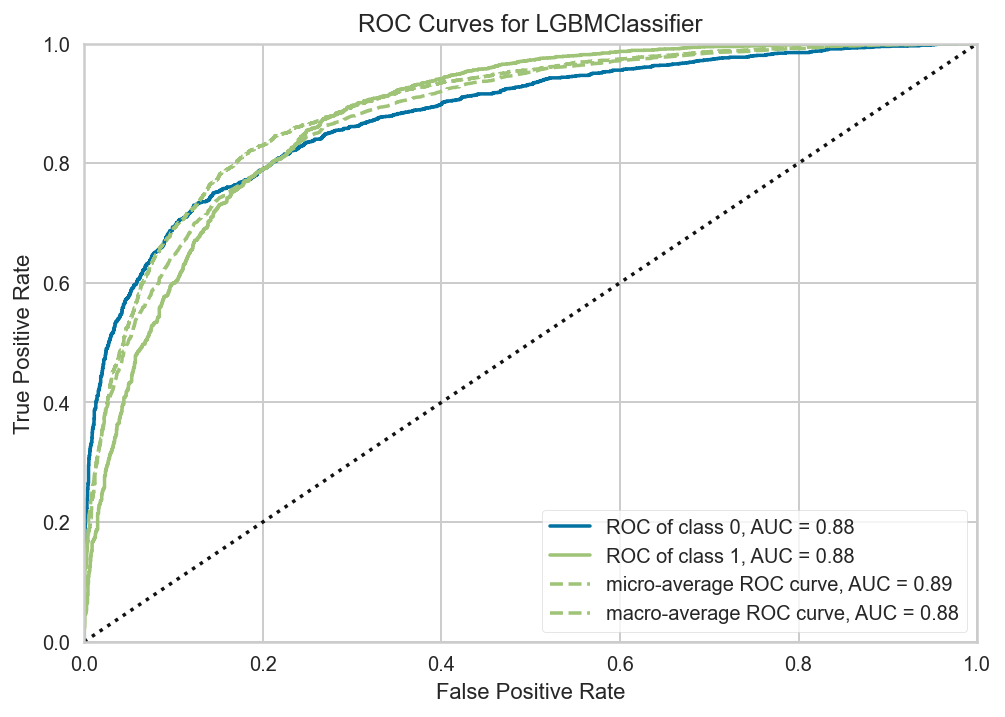

In [42]:
# AUC-ROC plot 
auc_roc = plot_model(lightgbm, plot='auc', scale = 2)

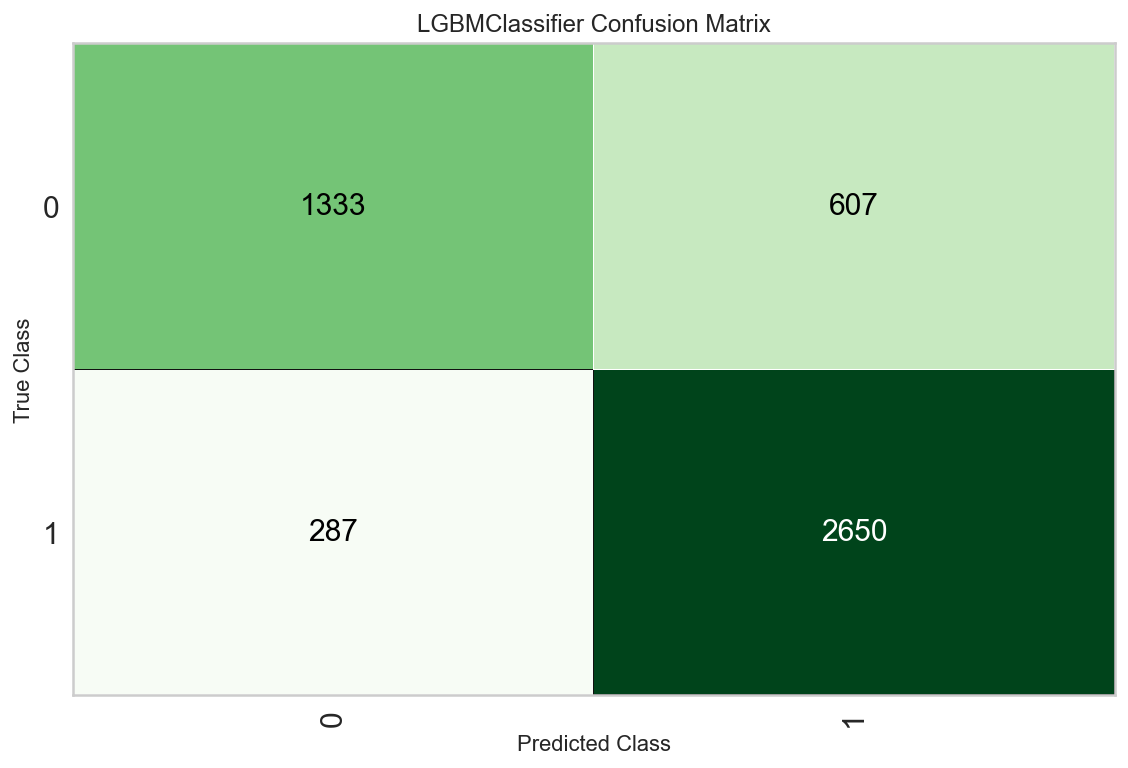

In [50]:
# confusion matrix
plot_model(lightgbm , plot = 'confusion_matrix',scale=2)

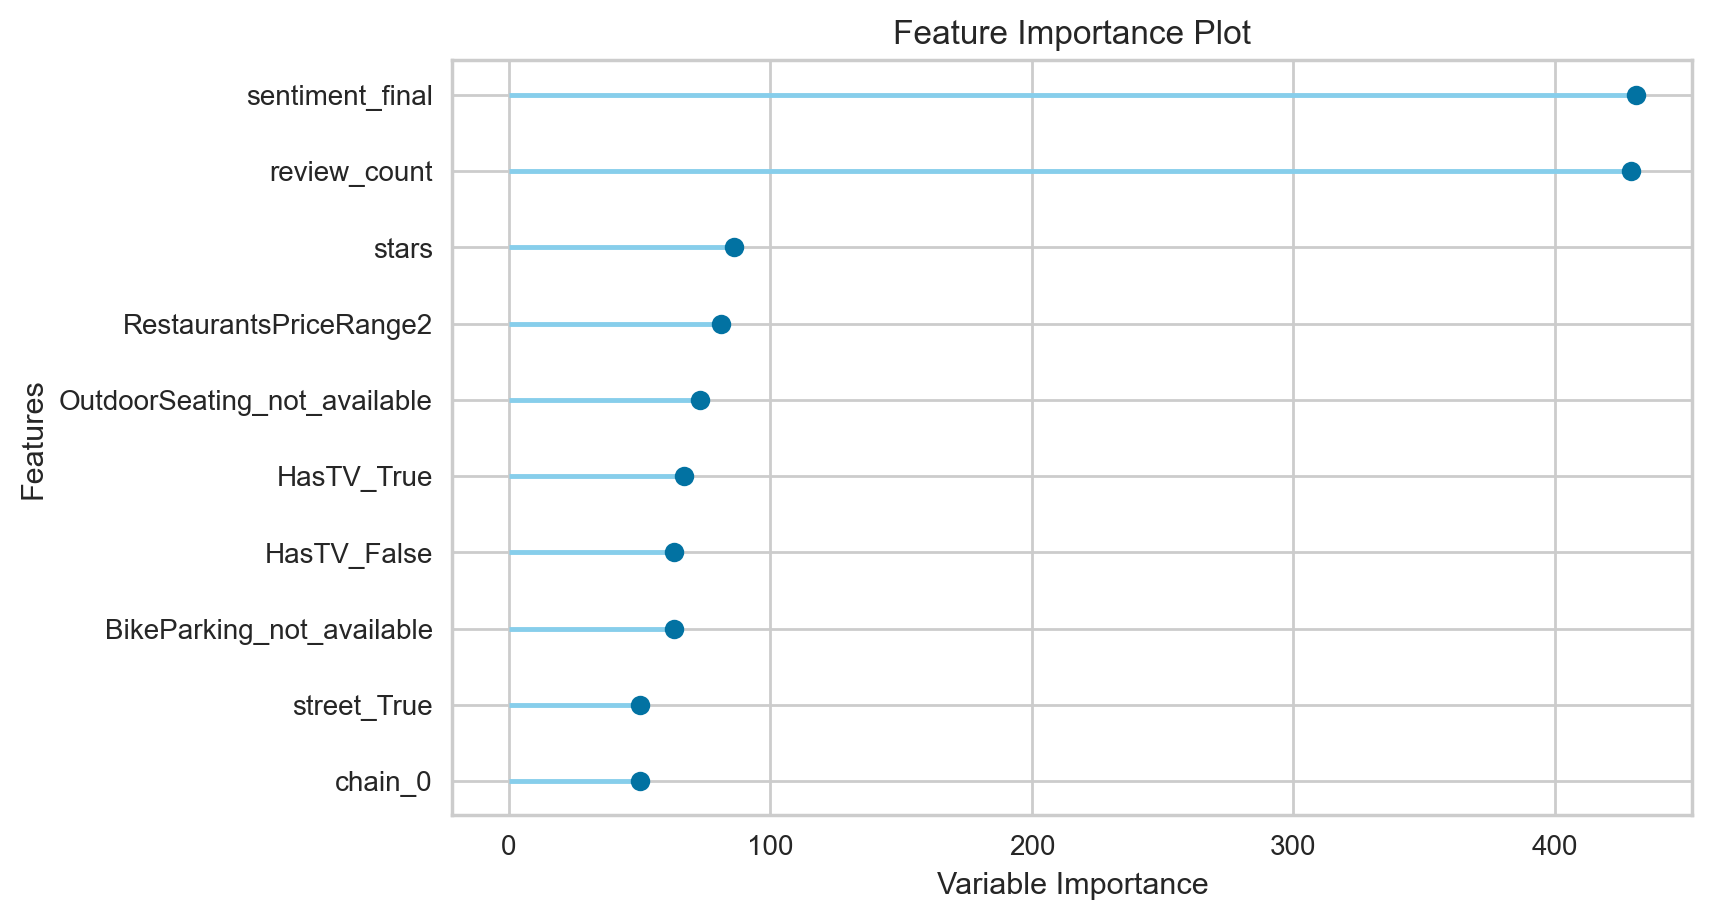

In [43]:
# Feature importance plot
plot_model(lightgbm, plot = 'feature', scale = 2)

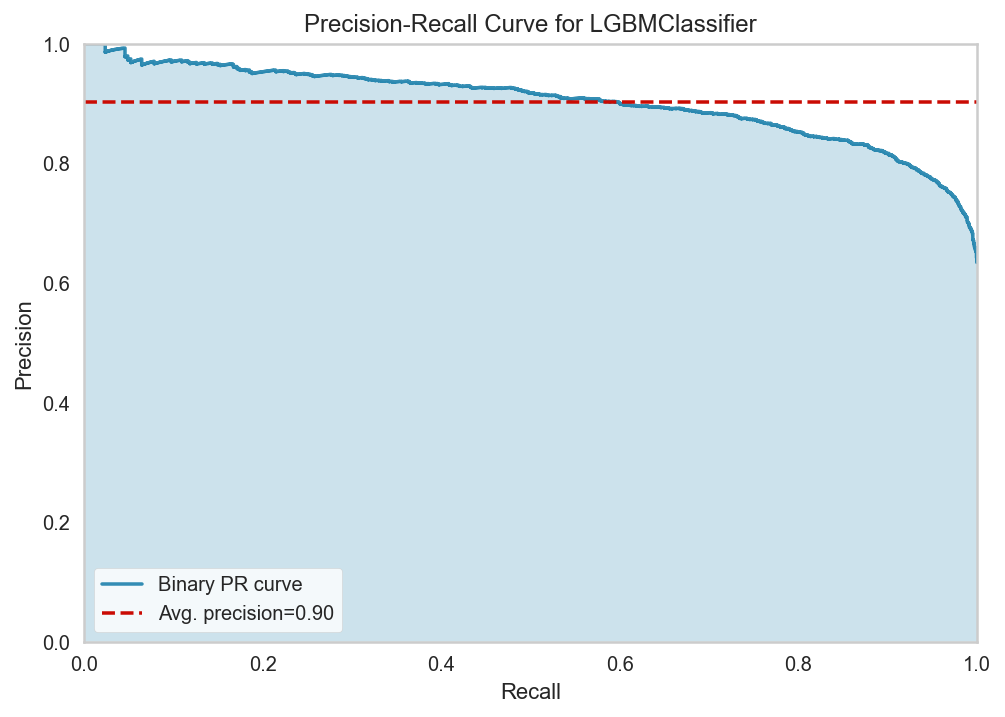

In [44]:
# Precision-Recall
pr = plot_model(lightgbm, plot='pr',scale=2)

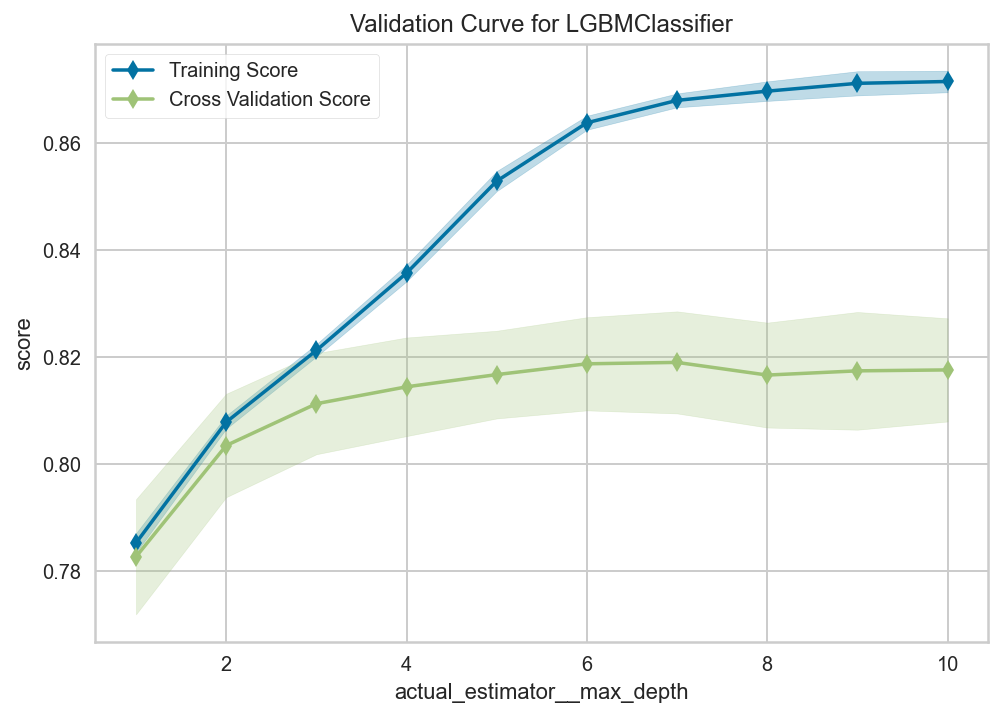

In [45]:
# Validation Curve
vc = plot_model(lightgbm, plot='vc',scale=2)

In [47]:
evaluate = evaluate_model(lightgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

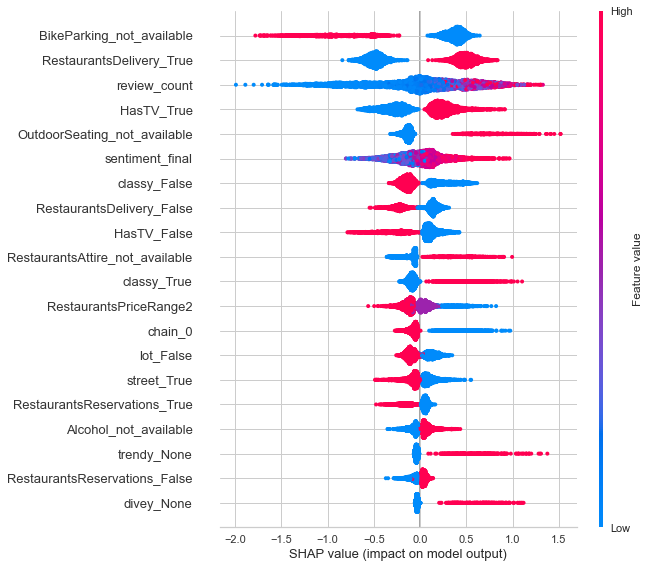

In [49]:
classification.interpret_model(lightgbm)

## Experiment with PCA = True

In [45]:
# setup environment
grid_pca = setup(data=df_restaurants_drop, target='is_open',
            html=False, silent=True, verbose=True, log_experiment= True, experiment_name = 'restaurants', pca = True, pca_method= 'kernel')

Setup Succesfully Completed!


,Description,Value
0,session_id,8122
1,Target,is_open
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(16256, 39)"
5,Missing Values,True
6,Numeric Features,6
7,Categorical Features,32
8,Ordinal Features,False
9,High Cardinality Features,False


In [46]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6608,0.6889,0.8192,0.6820,0.7444,0.2528,0.2623
1,0.6503,0.6554,0.8251,0.6706,0.7399,0.2233,0.2348
2,0.6670,0.6843,0.8149,0.6893,0.7468,0.2701,0.2783
3,0.6740,0.6995,0.8499,0.6851,0.7586,0.2740,0.2895
4,0.6520,0.6638,0.8280,0.6714,0.7415,0.2266,0.2386
5,0.6467,0.6597,0.8090,0.6719,0.7341,0.2212,0.2298
6,0.6652,0.6837,0.8076,0.6899,0.7441,0.2686,0.2756
7,0.6661,0.6852,0.8251,0.6852,0.7487,0.2638,0.2741
8,0.6731,0.6785,0.8397,0.6874,0.7559,0.2758,0.2888
9,0.6640,0.6851,0.8324,0.6814,0.7493,0.2551,0.2671


Comments: Model accuracy decreases with PCA = true

## Experiment with feature selection & remove outliers

In [54]:
# setup environment
grid_pca = setup(data=df_restaurants_drop, target='is_open',
            html=False, silent=True, verbose=True, log_experiment= True, experiment_name = 'restaurants',data_split_stratify=True, feature_selection=True )

Setup Succesfully Completed!


,Description,Value
0,session_id,4766
1,Target,is_open
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(16256, 39)"
5,Missing Values,True
6,Numeric Features,6
7,Categorical Features,32
8,Ordinal Features,False
9,High Cardinality Features,False


In [55]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8313,0.8921,0.9111,0.8267,0.8669,0.6381,0.6437
1,0.8225,0.8862,0.8950,0.8253,0.8587,0.6210,0.6247
2,0.8172,0.8853,0.8920,0.8201,0.8545,0.6098,0.6137
3,0.8260,0.8856,0.8818,0.8377,0.8592,0.6320,0.6334
4,0.8269,0.8927,0.8964,0.8297,0.8618,0.6312,0.6346
5,0.8137,0.8822,0.8861,0.8192,0.8513,0.6029,0.6063
6,0.8313,0.8910,0.9095,0.8274,0.8665,0.6388,0.6440
7,0.7979,0.8690,0.8657,0.8112,0.8376,0.5709,0.5730
8,0.8076,0.8798,0.8774,0.8166,0.8459,0.5906,0.5933
9,0.8223,0.8861,0.8964,0.8242,0.8587,0.6205,0.6245


In [56]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7963,0.8593,0.8659,0.8092,0.8365,0.5671,0.5695,2.121


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7963,0.8593,0.8659,0.8092,0.8365,0.5671,0.5695,2.121
knn,K Neighbors Classifier,0.7327,0.7757,0.7990,0.7669,0.7826,0.4359,0.4366,0.238


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7963,0.8593,0.8659,0.8092,0.8365,0.5671,0.5695,2.121
knn,K Neighbors Classifier,0.7327,0.7757,0.7990,0.7669,0.7826,0.4359,0.4366,0.238
nb,Naive Bayes,0.5497,0.7148,0.3325,0.8055,0.4704,0.1834,0.2389,0.044


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7963,0.8593,0.8659,0.8092,0.8365,0.5671,0.5695,2.121
dt,Decision Tree Classifier,0.7404,0.7293,0.7834,0.7849,0.7840,0.4586,0.4589,0.066
knn,K Neighbors Classifier,0.7327,0.7757,0.7990,0.7669,0.7826,0.4359,0.4366,0.238
nb,Naive Bayes,0.5497,0.7148,0.3325,0.8055,0.4704,0.1834,0.2389,0.044


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7963,0.8593,0.8659,0.8092,0.8365,0.5671,0.5695,2.121
dt,Decision Tree Classifier,0.7404,0.7293,0.7834,0.7849,0.7840,0.4586,0.4589,0.066
knn,K Neighbors Classifier,0.7327,0.7757,0.7990,0.7669,0.7826,0.4359,0.4366,0.238
svm,SVM - Linear Kernel,0.6870,0.0000,0.6766,0.7178,0.6604,0.3850,0.4162,0.084
nb,Naive Bayes,0.5497,0.7148,0.3325,0.8055,0.4704,0.1834,0.2389,0.044


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7963,0.8593,0.8659,0.8092,0.8365,0.5671,0.5695,2.121
ridge,Ridge Classifier,0.7938,0.0000,0.8754,0.8008,0.8364,0.5592,0.5633,0.039
dt,Decision Tree Classifier,0.7404,0.7293,0.7834,0.7849,0.7840,0.4586,0.4589,0.066
knn,K Neighbors Classifier,0.7327,0.7757,0.7990,0.7669,0.7826,0.4359,0.4366,0.238
svm,SVM - Linear Kernel,0.6870,0.0000,0.6766,0.7178,0.6604,0.3850,0.4162,0.084
nb,Naive Bayes,0.5497,0.7148,0.3325,0.8055,0.4704,0.1834,0.2389,0.044


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8172,0.8804,0.8949,0.8185,0.8550,0.6091,0.6137,0.314
lr,Logistic Regression,0.7963,0.8593,0.8659,0.8092,0.8365,0.5671,0.5695,2.121
ridge,Ridge Classifier,0.7938,0.0000,0.8754,0.8008,0.8364,0.5592,0.5633,0.039
dt,Decision Tree Classifier,0.7404,0.7293,0.7834,0.7849,0.7840,0.4586,0.4589,0.066
knn,K Neighbors Classifier,0.7327,0.7757,0.7990,0.7669,0.7826,0.4359,0.4366,0.238
svm,SVM - Linear Kernel,0.6870,0.0000,0.6766,0.7178,0.6604,0.3850,0.4162,0.084
nb,Naive Bayes,0.5497,0.7148,0.3325,0.8055,0.4704,0.1834,0.2389,0.044


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8172,0.8804,0.8949,0.8185,0.8550,0.6091,0.6137,0.314
lr,Logistic Regression,0.7963,0.8593,0.8659,0.8092,0.8365,0.5671,0.5695,2.121
ridge,Ridge Classifier,0.7938,0.0000,0.8754,0.8008,0.8364,0.5592,0.5633,0.039
dt,Decision Tree Classifier,0.7404,0.7293,0.7834,0.7849,0.7840,0.4586,0.4589,0.066
knn,K Neighbors Classifier,0.7327,0.7757,0.7990,0.7669,0.7826,0.4359,0.4366,0.238
svm,SVM - Linear Kernel,0.6870,0.0000,0.6766,0.7178,0.6604,0.3850,0.4162,0.084
nb,Naive Bayes,0.5497,0.7148,0.3325,0.8055,0.4704,0.1834,0.2389,0.044
qda,Quadratic Discriminant Analysis,0.4115,0.6553,0.0298,0.8113,0.0572,0.0152,0.0626,0.092


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8172,0.8804,0.8949,0.8185,0.8550,0.6091,0.6137,0.314
lr,Logistic Regression,0.7963,0.8593,0.8659,0.8092,0.8365,0.5671,0.5695,2.121
ridge,Ridge Classifier,0.7938,0.0000,0.8754,0.8008,0.8364,0.5592,0.5633,0.039
ada,Ada Boost Classifier,0.7901,0.8586,0.8597,0.8049,0.8314,0.5540,0.5562,0.373
dt,Decision Tree Classifier,0.7404,0.7293,0.7834,0.7849,0.7840,0.4586,0.4589,0.066
knn,K Neighbors Classifier,0.7327,0.7757,0.7990,0.7669,0.7826,0.4359,0.4366,0.238
svm,SVM - Linear Kernel,0.6870,0.0000,0.6766,0.7178,0.6604,0.3850,0.4162,0.084
nb,Naive Bayes,0.5497,0.7148,0.3325,0.8055,0.4704,0.1834,0.2389,0.044
qda,Quadratic Discriminant Analysis,0.4115,0.6553,0.0298,0.8113,0.0572,0.0152,0.0626,0.092


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8172,0.8804,0.8949,0.8185,0.8550,0.6091,0.6137,0.314
gbc,Gradient Boosting Classifier,0.8089,0.8781,0.8973,0.8070,0.8497,0.5893,0.5958,0.644
lr,Logistic Regression,0.7963,0.8593,0.8659,0.8092,0.8365,0.5671,0.5695,2.121
ridge,Ridge Classifier,0.7938,0.0000,0.8754,0.8008,0.8364,0.5592,0.5633,0.039
ada,Ada Boost Classifier,0.7901,0.8586,0.8597,0.8049,0.8314,0.5540,0.5562,0.373
dt,Decision Tree Classifier,0.7404,0.7293,0.7834,0.7849,0.7840,0.4586,0.4589,0.066
knn,K Neighbors Classifier,0.7327,0.7757,0.7990,0.7669,0.7826,0.4359,0.4366,0.238
svm,SVM - Linear Kernel,0.6870,0.0000,0.6766,0.7178,0.6604,0.3850,0.4162,0.084
nb,Naive Bayes,0.5497,0.7148,0.3325,0.8055,0.4704,0.1834,0.2389,0.044
qda,Quadratic Discriminant Analysis,0.4115,0.6553,0.0298,0.8113,0.0572,0.0152,0.0626,0.092


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8172,0.8804,0.8949,0.8185,0.8550,0.6091,0.6137,0.314
gbc,Gradient Boosting Classifier,0.8089,0.8781,0.8973,0.8070,0.8497,0.5893,0.5958,0.644
lr,Logistic Regression,0.7963,0.8593,0.8659,0.8092,0.8365,0.5671,0.5695,2.121
ridge,Ridge Classifier,0.7938,0.0000,0.8754,0.8008,0.8364,0.5592,0.5633,0.039
lda,Linear Discriminant Analysis,0.7934,0.8540,0.8729,0.8017,0.8357,0.5587,0.5625,0.164
ada,Ada Boost Classifier,0.7901,0.8586,0.8597,0.8049,0.8314,0.5540,0.5562,0.373
dt,Decision Tree Classifier,0.7404,0.7293,0.7834,0.7849,0.7840,0.4586,0.4589,0.066
knn,K Neighbors Classifier,0.7327,0.7757,0.7990,0.7669,0.7826,0.4359,0.4366,0.238
svm,SVM - Linear Kernel,0.6870,0.0000,0.6766,0.7178,0.6604,0.3850,0.4162,0.084
nb,Naive Bayes,0.5497,0.7148,0.3325,0.8055,0.4704,0.1834,0.2389,0.044


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8172,0.8804,0.8949,0.8185,0.8550,0.6091,0.6137,0.314
gbc,Gradient Boosting Classifier,0.8089,0.8781,0.8973,0.8070,0.8497,0.5893,0.5958,0.644
et,Extra Trees Classifier,0.8046,0.8684,0.8830,0.8097,0.8447,0.5824,0.5866,0.435
lr,Logistic Regression,0.7963,0.8593,0.8659,0.8092,0.8365,0.5671,0.5695,2.121
ridge,Ridge Classifier,0.7938,0.0000,0.8754,0.8008,0.8364,0.5592,0.5633,0.039
lda,Linear Discriminant Analysis,0.7934,0.8540,0.8729,0.8017,0.8357,0.5587,0.5625,0.164
ada,Ada Boost Classifier,0.7901,0.8586,0.8597,0.8049,0.8314,0.5540,0.5562,0.373
dt,Decision Tree Classifier,0.7404,0.7293,0.7834,0.7849,0.7840,0.4586,0.4589,0.066
knn,K Neighbors Classifier,0.7327,0.7757,0.7990,0.7669,0.7826,0.4359,0.4366,0.238
svm,SVM - Linear Kernel,0.6870,0.0000,0.6766,0.7178,0.6604,0.3850,0.4162,0.084


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8197,0.8850,0.8911,0.8238,0.8561,0.6156,0.6191,0.074
rf,Random Forest Classifier,0.8172,0.8804,0.8949,0.8185,0.8550,0.6091,0.6137,0.314
gbc,Gradient Boosting Classifier,0.8089,0.8781,0.8973,0.8070,0.8497,0.5893,0.5958,0.644
et,Extra Trees Classifier,0.8046,0.8684,0.8830,0.8097,0.8447,0.5824,0.5866,0.435
lr,Logistic Regression,0.7963,0.8593,0.8659,0.8092,0.8365,0.5671,0.5695,2.121
ridge,Ridge Classifier,0.7938,0.0000,0.8754,0.8008,0.8364,0.5592,0.5633,0.039
lda,Linear Discriminant Analysis,0.7934,0.8540,0.8729,0.8017,0.8357,0.5587,0.5625,0.164
ada,Ada Boost Classifier,0.7901,0.8586,0.8597,0.8049,0.8314,0.5540,0.5562,0.373
dt,Decision Tree Classifier,0.7404,0.7293,0.7834,0.7849,0.7840,0.4586,0.4589,0.066
knn,K Neighbors Classifier,0.7327,0.7757,0.7990,0.7669,0.7826,0.4359,0.4366,0.238


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8197,0.8850,0.8911,0.8238,0.8561,0.6156,0.6191,0.074
rf,Random Forest Classifier,0.8172,0.8804,0.8949,0.8185,0.8550,0.6091,0.6137,0.314
gbc,Gradient Boosting Classifier,0.8089,0.8781,0.8973,0.8070,0.8497,0.5893,0.5958,0.644
et,Extra Trees Classifier,0.8046,0.8684,0.8830,0.8097,0.8447,0.5824,0.5866,0.435
lr,Logistic Regression,0.7963,0.8593,0.8659,0.8092,0.8365,0.5671,0.5695,2.121
ridge,Ridge Classifier,0.7938,0.0000,0.8754,0.8008,0.8364,0.5592,0.5633,0.039
lda,Linear Discriminant Analysis,0.7934,0.8540,0.8729,0.8017,0.8357,0.5587,0.5625,0.164
ada,Ada Boost Classifier,0.7901,0.8586,0.8597,0.8049,0.8314,0.5540,0.5562,0.373
dt,Decision Tree Classifier,0.7404,0.7293,0.7834,0.7849,0.7840,0.4586,0.4589,0.066
knn,K Neighbors Classifier,0.7327,0.7757,0.7990,0.7669,0.7826,0.4359,0.4366,0.238


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8197,0.8850,0.8911,0.8238,0.8561,0.6156,0.6191,0.074
rf,Random Forest Classifier,0.8172,0.8804,0.8949,0.8185,0.8550,0.6091,0.6137,0.314
gbc,Gradient Boosting Classifier,0.8089,0.8781,0.8973,0.8070,0.8497,0.5893,0.5958,0.644
et,Extra Trees Classifier,0.8046,0.8684,0.8830,0.8097,0.8447,0.5824,0.5866,0.435
lr,Logistic Regression,0.7963,0.8593,0.8659,0.8092,0.8365,0.5671,0.5695,2.121
ridge,Ridge Classifier,0.7938,0.0000,0.8754,0.8008,0.8364,0.5592,0.5633,0.039
lda,Linear Discriminant Analysis,0.7934,0.8540,0.8729,0.8017,0.8357,0.5587,0.5625,0.164
ada,Ada Boost Classifier,0.7901,0.8586,0.8597,0.8049,0.8314,0.5540,0.5562,0.373
dt,Decision Tree Classifier,0.7404,0.7293,0.7834,0.7849,0.7840,0.4586,0.4589,0.066
knn,K Neighbors Classifier,0.7327,0.7757,0.7990,0.7669,0.7826,0.4359,0.4366,0.238


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=4766, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## Experiment with feature selection & polynomial_features

In [3]:
# setup environment
grid_pca = setup(data=df_restaurants_drop, target='is_open',
            html=False, silent=True, verbose=True, log_experiment= True, experiment_name = 'restaurants',data_split_stratify=True, feature_selection=True, polynomial_features=True)

NameError: name 'setup' is not defined

In [4]:
lightgbm = create_model('lightgbm')

NameError: name 'create_model' is not defined

### Analyse lightgbm with polynomial features & feature_selection=True

In [1]:
# AUC-ROC plot 
auc_roc = plot_model(lightgbm, plot='auc')

NameError: name 'plot_model' is not defined

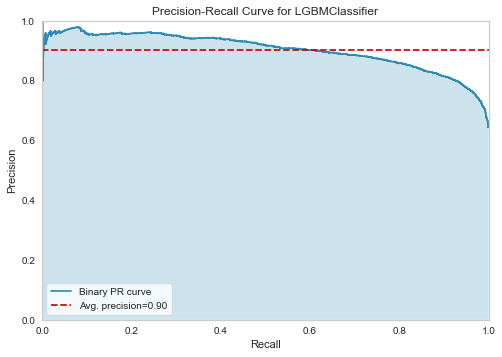

In [64]:
# Precision-Recall
pr = plot_model(lightgbm, plot='pr')

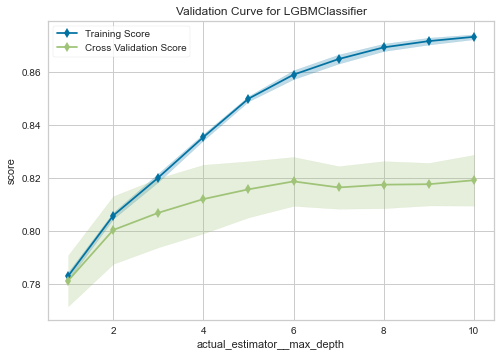

In [65]:
# Validation Curve
vc = plot_model(lightgbm, plot='vc')

In [66]:
evaluate = evaluate_model(lightgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

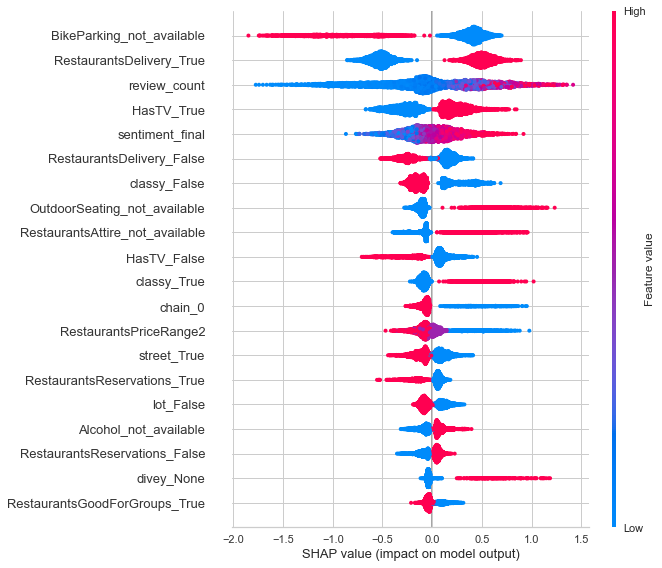

In [67]:
classification.interpret_model(lightgbm)

### Create dummy variables for categorical variables.

In [5]:
categorical_cols = df_restaurants.select_dtypes(include=['object'])
categorical_cols.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'category', 'RestaurantsTakeOut', 'GoodForKids', 'BikeParking',
       'OutdoorSeating', 'Caters', 'RestaurantsReservations',
       'RestaurantsDelivery', 'HasTV', 'RestaurantsGoodForGroups',
       'BusinessAcceptsCreditCards', 'casual', 'classy', 'divey', 'hipster',
       'intimate', 'romantic', 'touristy', 'trendy', 'upscale', 'garage',
       'lot', 'street', 'valet', 'validated', 'RestaurantsAttire', 'WiFi',
       'Alcohol'],
      dtype='object')

In [7]:
categorical_cols.drop(columns= cols_drop, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [8]:
categorical_cols_to_drop = list(categorical_cols.columns)
categorical_cols_to_drop

['city',
 'state',
 'category',
 'RestaurantsTakeOut',
 'GoodForKids',
 'BikeParking',
 'OutdoorSeating',
 'Caters',
 'RestaurantsReservations',
 'RestaurantsDelivery',
 'HasTV',
 'RestaurantsGoodForGroups',
 'BusinessAcceptsCreditCards',
 'casual',
 'classy',
 'divey',
 'hipster',
 'intimate',
 'romantic',
 'touristy',
 'trendy',
 'upscale',
 'garage',
 'lot',
 'street',
 'valet',
 'validated',
 'RestaurantsAttire',
 'WiFi',
 'Alcohol']

In [9]:
# Create dummy variables for categorical variables
dum_df = pd.get_dummies(categorical_cols,drop_first=True)
dum_df

,city_Aloha,city_Andover,city_Arlington,city_Auburndale,city_Avon,city_Back Bay,city_Beaverton,city_Bedford,city_Belmont,city_Beverly,...,garage_True,lot_True,street_True,valet_True,validated_True,RestaurantsAttire_dressy,RestaurantsAttire_formal,WiFi_None,Alcohol_beer_and_wine,Alcohol_full_bar
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16251,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,1,0
16252,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
16253,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
16254,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1


In [12]:
restaurants_dummy= pd.concat([df_restaurants, dum_df], axis=1 , join ='inner')
restaurants_dummy.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,garage_True,lot_True,street_True,valet_True,validated_True,RestaurantsAttire_dressy,RestaurantsAttire_formal,WiFi_None,Alcohol_beer_and_wine,Alcohol_full_bar
0,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,...,1,0,0,0,0,0,0,0,1,0
1,HPA_qyMEddpAEtFof02ixg,Mr G's Pizza & Subs,474 Lowell St,Peabody,MA,01960,42.541155,-70.973438,4.0,39,...,0,1,0,0,0,0,0,0,0,0
2,jGennaZUr2MsJyRhijNBfA,Legal Sea Foods,1 Harborside Dr,Boston,MA,02128,42.363442,-71.025781,3.5,856,...,1,0,0,0,0,0,0,0,0,1
3,iPD8BBvea6YldQZPHzVrSQ,Espresso Minute,334 Mass Ave,Boston,MA,02115,42.342673,-71.084239,4.5,7,...,0,0,0,0,0,0,0,0,0,0
4,jx91IMdGOmLOo8h_F9z39g,Cleary's Restaurant & Spirits,12429 NE Glisan St,Portland,OR,97230,45.526473,-122.535323,3.5,19,...,0,1,0,0,0,0,0,0,0,1


In [13]:
restaurants_dummy.drop(columns=categorical_cols_to_drop,inplace=True)

In [16]:
restaurants_dummy.head()

,business_id,name,address,postal_code,latitude,longitude,stars,review_count,is_open,RestaurantsPriceRange2,...,garage_True,lot_True,street_True,valet_True,validated_True,RestaurantsAttire_dressy,RestaurantsAttire_formal,WiFi_None,Alcohol_beer_and_wine,Alcohol_full_bar
0,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,97218,45.588906,-122.593331,4.0,126,1,2,...,1,0,0,0,0,0,0,0,1,0
1,HPA_qyMEddpAEtFof02ixg,Mr G's Pizza & Subs,474 Lowell St,01960,42.541155,-70.973438,4.0,39,1,2,...,0,1,0,0,0,0,0,0,0,0
2,jGennaZUr2MsJyRhijNBfA,Legal Sea Foods,1 Harborside Dr,02128,42.363442,-71.025781,3.5,856,1,2,...,1,0,0,0,0,0,0,0,0,1
3,iPD8BBvea6YldQZPHzVrSQ,Espresso Minute,334 Mass Ave,02115,42.342673,-71.084239,4.5,7,0,1,...,0,0,0,0,0,0,0,0,0,0
4,jx91IMdGOmLOo8h_F9z39g,Cleary's Restaurant & Spirits,12429 NE Glisan St,97230,45.526473,-122.535323,3.5,19,1,2,...,0,1,0,0,0,0,0,0,0,1


In [17]:
restaurants_dummy.drop(columns= cols_drop, inplace=True)

### Perform Train test split

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y )

In [54]:
# Instantiate StandardScaler
ss = StandardScaler()

# Fit and transform train.
X_train_sc = ss.fit_transform(X_train)

# Transform test.
X_test_sc = ss.transform(X_test)

## Baseline score

### Declare X and y variable 

In [22]:
X = df_restaurants_drop.drop(labels='is_open',axis=1)
y = df_restaurants_drop['is_open']

In [23]:
y_test.value_counts(normalize=True)

NameError: name 'y_test' is not defined

### Logistic Regression



In [70]:
#instantiate logistic regression and find the parameters for tuning the model
lr = LogisticRegression()
#lr.get_params()

In [72]:
lr.fit(X_train_sc, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [74]:
print(f'Logistic Regression Intercept: {lr.intercept_}')
print(f'Logistic Regression Coefficient: {lr.coef_}')

Logistic Regression Intercept: [0.63230682]
Logistic Regression Coefficient: [[ 6.29232915e-02  1.86821454e-01  8.73844100e-02  6.95448253e-01
  -2.61429042e-01 -7.77885301e-02  3.55928599e-01  3.66506237e-01
   6.89508375e-02  1.00777001e-01  1.72046896e-02  1.09756855e-01
   4.07645336e-02  1.90200026e-02  6.12177018e-02  2.28921078e-02
   4.70893304e-02  8.07614968e-02  5.00900063e-02  5.34016094e-02
   2.38776470e-01  0.00000000e+00  8.94862224e-02 -5.65311022e-03
   8.20768117e-02  1.94959443e-02 -5.43878263e-02  8.67913369e-02
   7.41073350e-02  5.65439022e-02  0.00000000e+00 -3.16991985e-03
   9.48211925e-02  1.88344299e-02  6.52437015e-02  8.86859643e-02
   1.24812286e-01  6.41704668e-02  6.04707454e-02  9.97395599e-02
   1.32827117e-01  4.07300603e-02  8.48761181e-02  8.87530385e-02
   4.44930936e-02  3.70647734e-02  5.80817770e-02  1.10945125e-01
   6.44860406e-02 -1.19842332e-02  4.84425173e-02  5.83462987e-02
   8.76424166e-02  5.90913088e-02  4.76234631e-02  5.45540424e-02

In [78]:
lr.score(X_train_sc, y_train)

0.7661488772685328

In [79]:
lr.score(X_test_sc, y_test)

0.7699876998769988

In [ ]:
lr_params = { 'C': np.logspace(-4, 4, 20) ,
                  'solver': ['newton-cg', 'lbfgs', 'liblinear'],
                  #'penalty': ['l1', 'l2', 'elasticnet']
            }

In [ ]:
# Instantiate GridSearchCV object.
gs_lr= GridSearchCV(lr,
                    param_grid = lr_params,
                    cv=5)

In [ ]:
gs_lr.fit(X_train_sc, y_train)

In [ ]:
gs_lr.best_params_

In [63]:
# Get Predictions
lr_predict = gs_lr.predict(X_test)

# Save into confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, lr_predict).ravel()
print(tn, fp, fn, tp)

1294 0 1958 0


In [64]:
# create function to obtain model score
def get_score(model,Xtrain,ytrain, Xtest, ytest, predict):
    print('Model:', model.estimator )
    print('Gridsearch best score:', model.best_score_)
    print('Training set score:', model.score(Xtrain, ytrain))
    print('Testing set score:', model.score(Xtest, ytest))
    print('f1 score:', f1_score(ytest, predict))

In [65]:
get_score(gs_lr,X_train_sc,y_train,X_test_sc,y_test,lr_predict)

Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Gridsearch best score: 0.7575369828172596
Training set score: 0.7686865579821593
Testing set score: 0.7727552275522755
f1 score: 0.0


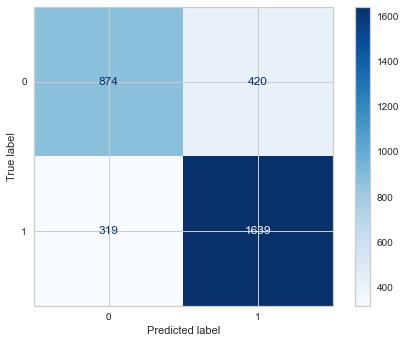

In [80]:
# View confusion matrix
plot_confusion_matrix(gs_lr, X_test_sc, y_test, cmap='Blues', values_format='d')